In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm
from pulp import *
from scipy.optimize import minimize

import opendatasets as od
from IPython.core.display import display, HTML
display(HTML("<style>.container { width : 98% !important; }</style>"))

pd.set_option('display.max_columns',500)

In [2]:
url = "https://raw.githubusercontent.com/axpinkerton/Retail_example_notebooks/main/price_optimization_transform/newdata.xlsx"
df=pd.read_excel(url)
df.head(10)

,order_id,order_date,ship_date,ship_mode,customer_name,segment,state,country,market,region,product_id,category,sub_category,product_name,product_name.1,product_name.2,product_name.3,product_name.4,product_name.5,Unit Price,quantity,discount,shipping_cost,order_priority,sales,expenses,revenue,year
0,AG-2011-2040,2011-01-01,2011-01-06,Standard Class,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,Africa,OFF-TEN-10000025,OFFICE SUPPLIES,STORAGE,Tenex Lockers,Blue,NaN,NaN,NaN,NaN,211,2,0.0,35.46,Medium,422,397.9902,457.46,2011
1,IN-2011-47883,2011-01-01,2011-01-08,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,OFF-SU-10000618,OFFICE SUPPLIES,SUPPLIES,Acme Trimmer,High Speed,NaN,NaN,NaN,NaN,129,3,0.1,9.72,Medium,387,311.4774,358.02,2011
2,HU-2011-1220,2011-01-01,2011-01-05,Second Class,Annie Thurman,Consumer,Budapest,Hungary,EMEA,EMEA,OFF-TEN-10001585,OFFICE SUPPLIES,STORAGE,Tenex Box,Single Width,NaN,NaN,NaN,NaN,128,4,0.0,8.17,High,512,452.5479,520.17,2011
3,IT-2011-3647632,2011-01-01,2011-01-05,Second Class,Eugene Moren,Home Office,Stockholm,Sweden,EU,North,OFF-PA-10001492,OFFICE SUPPLIES,PAPER,Enermax Note Cards,Premium,NaN,NaN,NaN,NaN,177,3,0.5,4.82,High,531,235.1784,270.32,2011
4,CA-2011-1510,2011-01-01,2011-01-08,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,FUR-FU-10003447,FURNITURE,FURNISHINGS,Eldon Light Bulb,Duo Pack,NaN,NaN,NaN,NaN,222,5,0.1,4.70,Medium,1110,873.2190,1003.70,2088
5,IN-2011-79397,2011-01-01,2011-01-08,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,OFF-PA-10001968,OFFICE SUPPLIES,PAPER,Eaton Computer Printout Paper,8.5 x 11,NaN,NaN,NaN,NaN,299,2,0.1,1.80,Medium,598,469.8000,540.00,2011
6,ID-2011-80230,2011-01-02,2011-01-06,Standard Class,Magdelene Morse,Consumer,Ontario,Canada,Canada,Canada,TEC-OKI-10002750,TECHNOLOGY,MACHINES,Okidata Inkjet,Wireless,NaN,NaN,NaN,NaN,378,1,0.0,24.10,Medium,378,349.8270,402.10,2011
7,IZ-2011-4680,2011-01-03,2011-01-03,Same Day,Kean Nguyen,Corporate,New South Wales,Australia,APAC,Oceania,OFF-AP-10000304,OFFICE SUPPLIES,APPLIANCES,Hoover Microwave,White,NaN,NaN,NaN,NaN,254,1,0.1,125.32,Critical,254,307.9104,353.92,2011
8,IN-2011-65159,2011-01-03,2011-01-09,Standard Class,Ken Lonsdale,Consumer,Auckland,New Zealand,APAC,Oceania,TEC-CO-10004182,TECHNOLOGY,COPIERS,Hewlett Wireless Fax,Laser,NaN,NaN,NaN,NaN,400,4,0.4,107.10,Low,1600,928.3770,1067.10,2011
9,ES-2011-4869686,2011-01-03,2011-01-07,Standard Class,Lindsay Williams,Corporate,Ninawa,Iraq,EMEA,EMEA,FUR-NOV-10002791,FURNITURE,CHAIRS,Novimex Swivel Stool,Set of Two,NaN,NaN,NaN,NaN,60,4,0.0,81.26,High,240,279.4962,321.26,2001


In [3]:
# Converting & cleaning some of the columns up 
cols1 = df.columns
cols2=[]
for x in cols1:
    cols2.append(x.strip().replace(' ','_'))
df.columns=cols2
df['order_date'] = pd.to_datetime(df['order_date'])
df['year_wk'] = df['order_date'].dt.year.astype(str)+ '-' + (df['order_date'].dt.weekofyear).astype(str)
df['revenue'].fillna(0,inplace=True)
df['quantity'].fillna(0,inplace=True)
df['margin'] = df['revenue'] - df['expenses']
df

/var/folders/0g/4l0cmb9j43jgr0cxr8nx6sdm0000gn/T/ipykernel_13866/2263536988.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['year_wk'] = df['order_date'].dt.year.astype(str)+ '-' + (df['order_date'].dt.weekofyear).astype(str)


,order_id,order_date,ship_date,ship_mode,customer_name,segment,state,country,market,region,product_id,category,sub_category,product_name,product_name.1,product_name.2,product_name.3,product_name.4,product_name.5,Unit_Price,quantity,discount,shipping_cost,order_priority,sales,expenses,revenue,year,year_wk,margin
0,AG-2011-2040,2011-01-01,2011-01-06,Standard Class,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,Africa,OFF-TEN-10000025,OFFICE SUPPLIES,STORAGE,Tenex Lockers,Blue,NaN,NaN,NaN,NaN,211,2,0.00,35.46,Medium,422,397.9902,457.46,2011,2011-52,59.4698
1,IN-2011-47883,2011-01-01,2011-01-08,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,OFF-SU-10000618,OFFICE SUPPLIES,SUPPLIES,Acme Trimmer,High Speed,NaN,NaN,NaN,NaN,129,3,0.10,9.72,Medium,387,311.4774,358.02,2011,2011-52,46.5426
2,HU-2011-1220,2011-01-01,2011-01-05,Second Class,Annie Thurman,Consumer,Budapest,Hungary,EMEA,EMEA,OFF-TEN-10001585,OFFICE SUPPLIES,STORAGE,Tenex Box,Single Width,NaN,NaN,NaN,NaN,128,4,0.00,8.17,High,512,452.5479,520.17,2011,2011-52,67.6221
3,IT-2011-3647632,2011-01-01,2011-01-05,Second Class,Eugene Moren,Home Office,Stockholm,Sweden,EU,North,OFF-PA-10001492,OFFICE SUPPLIES,PAPER,Enermax Note Cards,Premium,NaN,NaN,NaN,NaN,177,3,0.50,4.82,High,531,235.1784,270.32,2011,2011-52,35.1416
4,CA-2011-1510,2011-01-01,2011-01-08,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,FUR-FU-10003447,FURNITURE,FURNISHINGS,Eldon Light Bulb,Duo Pack,NaN,NaN,NaN,NaN,222,5,0.10,4.70,Medium,1110,873.2190,1003.70,2088,2011-52,130.4810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51313,MO-2014-8720,2014-09-20,2014-09-24,Standard Class,Alan Hwang,Consumer,Catalonia,Cameroon,Africa,Africa,OFF-ACC-10004871,OFFICE SUPPLIES,BINDERS,Acco Binder Covers,Economy,NaN,NaN,NaN,NaN,195,1,0.00,0.98,High,195,170.5026,195.98,2014,2014-38,25.4774
51314,IN-2014-75736,2014-09-21,2014-09-27,Standard Class,Seth Vernon,Consumer,New York,Indonesia,APAC,Southeast Asia,OFF-SU-10001382,OFFICE SUPPLIES,SUPPLIES,Acme Trimmer,Serrated,NaN,NaN,NaN,NaN,239,1,0.47,0.96,Medium,239,111.0381,127.63,2014,2014-38,16.5919
51315,CA-2014-121580,2014-09-23,2014-09-27,Standard Class,Hallie Redmond,Home Office,Panama,Egypt,Africa,Africa,OFF-STO-10002042,OFFICE SUPPLIES,FASTENERS,Stockwell Staples,Metal,NaN,NaN,NaN,NaN,27,1,0.00,0.96,Medium,27,24.3252,27.96,2014,2014-39,3.6348
51316,IN-2014-65131,2014-09-23,2014-09-29,Standard Class,Trudy Schmidt,Consumer,Goiás,United States,US,Central,FUR-FU-10004586,FURNITURE,FURNISHINGS,G.E. Longer-Life Indoor Recessed Floodlight Bulbs,NaN,NaN,NaN,NaN,NaN,143,3,0.60,0.87,High,429,150.0489,172.47,2014,2014-39,22.4211


In [4]:
# Grouping and aggregating by product ID and week/year to get enough data points to be significant. I'm using the revenue column in order to see the ending 
# price that was actually paid by the customer to receive the item -- the retailer has the ability to change the price of all of the aspects that end up going 
# into the ending price paid (e.g. they could offer free shipping instead of making a customer pay for shipping). Tax is not controlled by the retailer of course
agg_df = df.groupby(['product_id','year_wk'])[['revenue','margin','quantity']].agg(np.sum).reset_index()
agg_df['unit_price'] = agg_df['revenue'] / agg_df['quantity']
agg_df['unit_margin'] = agg_df['margin'] / agg_df['quantity']
agg_df

,product_id,year_wk,revenue,margin,quantity,unit_price,unit_margin
0,FUR-ADV-10000002,2014-21,104.11,13.5343,2,52.0550,6.767150
1,FUR-ADV-10000002,2014-38,419.03,54.4739,1,419.0300,54.473900
2,FUR-ADV-10000108,2011-15,631.27,82.0651,2,315.6350,41.032550
3,FUR-ADV-10000108,2012-19,391.83,50.9379,1,391.8300,50.937900
4,FUR-ADV-10000108,2012-8,1154.80,150.1240,4,288.7000,37.531000
...,...,...,...,...,...,...,...
50301,TEC-STA-10004542,2014-23,1012.66,131.6458,4,253.1650,32.911450
50302,TEC-STA-10004542,2014-30,4136.22,537.7086,15,275.7480,35.847240
50303,TEC-STA-10004834,2011-44,533.61,69.3693,4,133.4025,17.342325
50304,TEC-STA-10004834,2013-35,51.97,6.7561,1,51.9700,6.756100


In [5]:
# log transforming my avg. prices, margins, and unit sales to get a more normal distribution 
agg_df['log_quantity'] = np.log(agg_df['quantity'])
agg_df['log_price'] = np.log(agg_df['unit_price'])
agg_df['log_margin'] = np.log(agg_df['unit_margin'])
agg_df

,product_id,year_wk,revenue,margin,quantity,unit_price,unit_margin,log_quantity,log_price,log_margin
0,FUR-ADV-10000002,2014-21,104.11,13.5343,2,52.0550,6.767150,0.693147,3.952301,1.912080
1,FUR-ADV-10000002,2014-38,419.03,54.4739,1,419.0300,54.473900,0.000000,6.037943,3.997722
2,FUR-ADV-10000108,2011-15,631.27,82.0651,2,315.6350,41.032550,0.693147,5.754586,3.714366
3,FUR-ADV-10000108,2012-19,391.83,50.9379,1,391.8300,50.937900,0.000000,5.970828,3.930607
4,FUR-ADV-10000108,2012-8,1154.80,150.1240,4,288.7000,37.531000,1.386294,5.665388,3.625167
...,...,...,...,...,...,...,...,...,...,...
50301,TEC-STA-10004542,2014-23,1012.66,131.6458,4,253.1650,32.911450,1.386294,5.534041,3.493821
50302,TEC-STA-10004542,2014-30,4136.22,537.7086,15,275.7480,35.847240,2.708050,5.619487,3.579267
50303,TEC-STA-10004834,2011-44,533.61,69.3693,4,133.4025,17.342325,1.386294,4.893371,2.853150
50304,TEC-STA-10004834,2013-35,51.97,6.7561,1,51.9700,6.756100,0.000000,3.950667,1.910446


In [6]:
# I am fitting a linear model to the log price (independent variable) and log quantity (dependent variable) for each product
# after fitting the OLS model, i want to look at the p-value for the log-price variable (just the log-price p-value, don't really need to look
# for the intercept p-value for this purpose) to make sure that I can expect SOME reasonable results from the regression model fitted on the price-quantity
# sales data (and to make sure there is enough data points)

# I'm adding the products with a p-value of less than .05 / 5% to a list so that I can reference these products for later work below

significant_products = []
for prod in np.unique(agg_df['product_id']):
    try:
        prod_df = agg_df[agg_df['product_id']==prod].copy()
        x = prod_df['log_price']
        y = prod_df['log_quantity']
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        if model.pvalues.loc['log_price']<.05:
            significant_products.append(prod)
    except:
        continue

In [7]:
# Example of products
print(significant_products[0],', ... , ',significant_products[-1])

FUR-ADV-10000183 , ... ,  TEC-STA-10002650


In [8]:
# Only 398 out of 10292 products have enough sales data to get a significant result from the fit model, or about 4% of products
a = len(significant_products)
b = len(np.unique(agg_df['product_id']))

print('Significant Products: ',a)
print('Total Products: ',b)
print('% of Ttl products that have significant result: ',a/b)

Significant Products:  398
Total Products:  10292
% of Ttl products that have significant result:  0.038670812281383596


<AxesSubplot:title={'center':'FUR-ADV-10000183'}, xlabel='log_price', ylabel='log_quantity'>

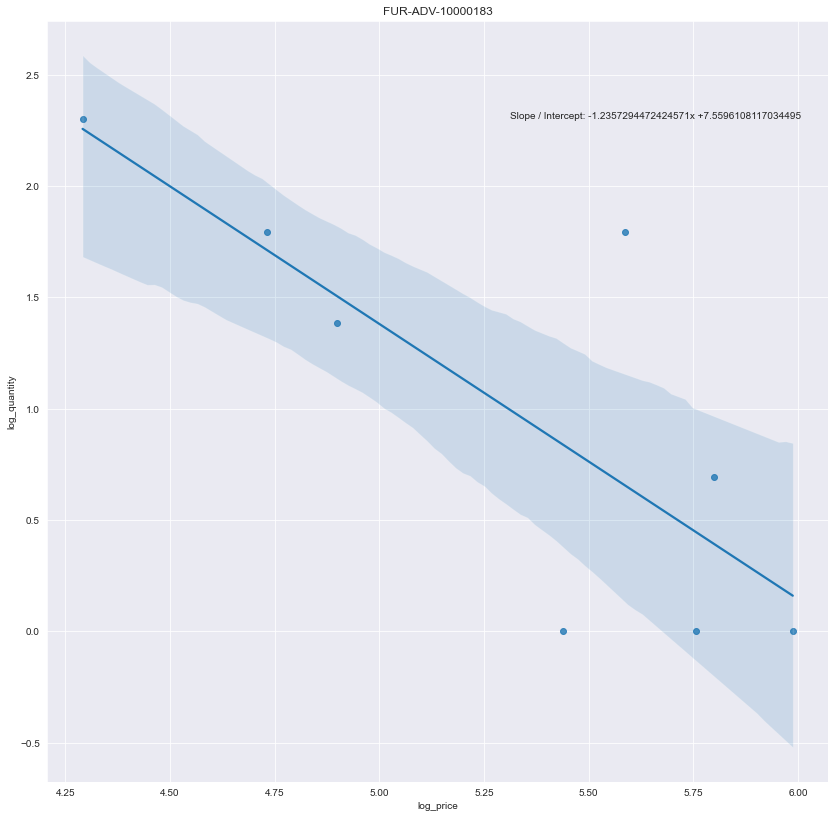

In [9]:
# Just one regression scatter plot example of a product showing the price / unit sale variables
# The line and confidence interval 

product1 = significant_products[0]
product1_df = agg_df[agg_df['product_id']==product1].copy()
x=product1_df['log_price']
y=product1_df['log_quantity']

ols = sm.OLS(y,sm.add_constant(x)).fit()
intercept , slope = ols.params

sns.set_style('darkgrid')
plt.figure(figsize=(14,14))
plt.text(x=np.mean(x),y=max(y),s=('Slope / Intercept: '+str(slope)+'x +'+str(intercept)))
plt.title(product1_df['product_id'].iloc[0])
sns.regplot(x=x,y=y)



In [10]:
# Creating a dataframe with just the significant product & their data points
relevant_df = agg_df[agg_df['product_id'].isin(significant_products)].copy()
ddff = relevant_df.sort_values(by=['product_id','log_price'],ascending=True)
ddff

,product_id,year_wk,revenue,margin,quantity,unit_price,unit_margin,log_quantity,log_price,log_margin
6,FUR-ADV-10000183,2012-46,730.76,94.9988,10,73.076000,9.499880,2.302585,4.291500,2.251279
8,FUR-ADV-10000183,2013-2,681.50,88.5950,6,113.583333,14.765833,1.791759,4.732537,2.692316
10,FUR-ADV-10000183,2014-35,537.14,69.8282,4,134.285000,17.457050,1.386294,4.899964,2.859744
12,FUR-ADV-10000183,2014-6,230.35,29.9455,1,230.350000,29.945500,0.000000,5.439600,3.399379
9,FUR-ADV-10000183,2013-30,1602.03,208.2639,6,267.005000,34.710650,1.791759,5.587267,3.547047
...,...,...,...,...,...,...,...,...,...,...
50255,TEC-STA-10002650,2014-1,76.59,9.9567,1,76.590000,9.956700,0.000000,4.338467,2.298246
50252,TEC-STA-10002650,2013-19,85.06,11.0578,1,85.060000,11.057800,0.000000,4.443357,2.403136
50256,TEC-STA-10002650,2014-39,204.81,26.6253,2,102.405000,13.312650,0.693147,4.628936,2.588715
50254,TEC-STA-10002650,2013-9,227.76,29.6088,2,113.880000,14.804400,0.693147,4.735145,2.694924


In [11]:
# Adding in the price elasticity of demand, product by product, and then combining them all into a single dataframe
empty_df=pd.DataFrame(columns=['product_id', 'year_wk', 'revenue', 'margin', 'quantity', 'unit_price',
       'unit_margin', 'log_quantity', 'log_price', 'log_margin','price_elast_demand'])

for ind_product in np.unique(ddff['product_id']):
    new_df = ddff[ddff['product_id']==ind_product].copy()
    new_df['price_elast_demand']=(new_df['log_quantity'].pct_change() / new_df['log_price'].pct_change())
    empty_df = pd.concat([empty_df,new_df])

empty_df

,product_id,year_wk,revenue,margin,quantity,unit_price,unit_margin,log_quantity,log_price,log_margin,price_elast_demand
6,FUR-ADV-10000183,2012-46,730.76,94.9988,10,73.076,9.49988,2.302585,4.2915,2.251279,NaN
8,FUR-ADV-10000183,2013-2,681.5,88.595,6,113.583333,14.765833,1.791759,4.732537,2.692316,-2.158695
10,FUR-ADV-10000183,2014-35,537.14,69.8282,4,134.285,17.45705,1.386294,4.899964,2.859744,-6.396474
12,FUR-ADV-10000183,2014-6,230.35,29.9455,1,230.35,29.9455,0.0,5.4396,3.399379,-9.080138
9,FUR-ADV-10000183,2013-30,1602.03,208.2639,6,267.005,34.71065,1.791759,5.587267,3.547047,inf
...,...,...,...,...,...,...,...,...,...,...,...
50255,TEC-STA-10002650,2014-1,76.59,9.9567,1,76.59,9.9567,0.0,4.338467,2.298246,NaN
50252,TEC-STA-10002650,2013-19,85.06,11.0578,1,85.06,11.0578,0.0,4.443357,2.403136,NaN
50256,TEC-STA-10002650,2014-39,204.81,26.6253,2,102.405,13.31265,0.693147,4.628936,2.588715,inf
50254,TEC-STA-10002650,2013-9,227.76,29.6088,2,113.88,14.8044,0.693147,4.735145,2.694924,0.0


In [12]:
# Creating a dataframe with just the relevant log-transformed slope & intercept formula with the product ID, so I can do a optimization / maximization
# for each product (and associated revenue amount)

empt=pd.DataFrame(columns=['product_id','regression_line','slope','intercept'])
for prod in np.unique(empty_df['product_id']):
    df1 = empty_df[empty_df['product_id']==prod].copy()
    x1 = np.asarray(sm.add_constant(df1['log_price']), dtype=float)
    y1 = np.asarray(df1['log_quantity'], dtype=float)
    mdl = sm.OLS(y1,x1,missing='drop').fit()
    intercept, slope = mdl.params
    rnd_intercept = round(intercept,3)
    rnd_slope = round(slope,3)
    regression_line = str(rnd_slope)+'x'+str(rnd_intercept)
    dfA = pd.DataFrame([[prod,str(rnd_slope)+'x +'+str(rnd_intercept),slope,intercept]],columns=['product_id','regression_line','slope','intercept'])
    empt=pd.concat([empt,dfA])
empt

,product_id,regression_line,slope,intercept
0,FUR-ADV-10000183,-1.236x +7.56,-1.235729,7.559611
0,FUR-ADV-10004395,-0.649x +3.707,-0.649186,3.707145
0,FUR-BO-10000034,-0.86x +4.455,-0.860279,4.454649
0,FUR-BO-10000468,-0.9x +5.45,-0.900321,5.450473
0,FUR-BO-10000967,1.69x +-7.52,1.690066,-7.520089
...,...,...,...,...
0,TEC-PH-10004833,-0.911x +6.087,-0.910521,6.086902
0,TEC-PH-10004959,1.337x +-6.078,1.337208,-6.07792
0,TEC-SAN-10000260,-0.544x +2.819,-0.544198,2.819176
0,TEC-STA-10000893,0.636x +-2.959,0.635882,-2.958991


In [13]:
# The quantity of the above regression line is equal to the ((slope * price) + intercept), so i can simplify the revenue equation to find the maximum
# revenue point by multiplying ((slope * price) + intercept) * price and maximizing that function

# For each product in the dataframe, I'm finding the revenue curve & then finding the maximum revenue amount & associated price. I'm using the SciPy minimize
# and then returning the negative to get around the fact that I can't do Maximize in SciPy. I'm not using PuLP, since PuLP only works for lienar programming
# and this problem involves raising price to an exponent.

# Adding all of the results to a dataframe once results are returned

res_df = pd.DataFrame(columns=['product_id','maximizing_price','max_revenue'])

for product in empt['product_id']:
    df = empt[empt['product_id']==product].copy()
    m = df['slope'][0]
    b = df['intercept'][0]
    
    def rev(x):
        price = x[0]
        revenue = ((m * price)+b)*price
        return -revenue
    x_start = -100
#     cons = ({'type':'eq','fun':lambda x : x})
#     bnds = (0,None)
    result = minimize(rev
                      , x_start
#                       , constraints=cons
#                       , bounds=bnds
                      , tol=.00000000000000000000001
)
    if result.success:
        res_dic = {'product_id':product,'maximizing_price':np.exp(result.x),'max_revenue':np.exp(-result.fun)}
        inter = pd.DataFrame(res_dic)
        res_df = pd.concat([res_df,inter],ignore_index=True)
        print(f"product: {product} revenue maximizing price = ${np.exp(result.x)} revenue = {np.exp(-result.fun)}")    
    else:
        res_dic = {'product_id':product,'maximizing_price':['Could not optimize'],'max_revenue':['Could not optimize']}
        inter = pd.DataFrame(res_dic)
        res_df = pd.concat([res_df,inter],ignore_index=True)
        print(f"product: {product}",'Could not optimize')
    

product: FUR-ADV-10000183 revenue maximizing price = $[21.3012237] revenue = 104981.00602787692
product: FUR-ADV-10004395 revenue maximizing price = $[17.37838131] revenue = 198.81409545665414
product: FUR-BO-10000034 revenue maximizing price = $[13.31740502] revenue = 319.48283131669456
product: FUR-BO-10000468 revenue maximizing price = $[20.63445625] revenue = 3824.517777319502
product: FUR-BO-10000967 Could not optimize
product: FUR-BO-10001155 Could not optimize
product: FUR-BO-10001372 Could not optimize
product: FUR-BO-10001641 Could not optimize
product: FUR-BO-10002032 Could not optimize
product: FUR-BO-10002277 Could not optimize
product: FUR-BO-10002738 Could not optimize
product: FUR-BO-10003631 revenue maximizing price = $[24.04538555] revenue = 7223.079912649902
product: FUR-BO-10004015 revenue maximizing price = $[51.30851826] revenue = 1459.5899945278084
product: FUR-BO-10004161 Could not optimize
product: FUR-BO-10004445 Could not optimize
product: FUR-BO-10004508 Coul

product: OFF-ELD-10001318 Could not optimize
product: OFF-ELD-10001882 revenue maximizing price = $[19.09776444] revenue = 781.0101024223521
product: OFF-ELD-10003038 revenue maximizing price = $[22.68494035] revenue = 29.1993619437007
product: OFF-ELI-10001057 Could not optimize
product: OFF-EN-10000139 revenue maximizing price = $[61.57269817] revenue = 1114.2401400384024
product: OFF-EN-10000897 revenue maximizing price = $[37.95505281] revenue = 212461.4588054579
product: OFF-EN-10001538 revenue maximizing price = $[60.84103662] revenue = 1431.5791487053098
product: OFF-EN-10002581 Could not optimize
product: OFF-EN-10002710 revenue maximizing price = $[16.67853705] revenue = 699.4405493613526
product: OFF-EN-10003537 Could not optimize
product: OFF-EN-10003559 revenue maximizing price = $[49.9786163] revenue = 6644.615745129105
product: OFF-EN-10003845 revenue maximizing price = $[52.33347997] revenue = 363.17849128692905
product: OFF-EN-10004410 revenue maximizing price = $[58.38

product: OFF-SU-10003723 Could not optimize
product: OFF-SU-10004110 Could not optimize
product: OFF-SU-10004279 Could not optimize
product: OFF-SU-10004655 revenue maximizing price = $[28.2232057] revenue = 6025.264052652741
product: OFF-SU-10004737 Could not optimize
product: OFF-SU-10004899 revenue maximizing price = $[14.90697236] revenue = 25567.1017803193
product: OFF-TEN-10000025 revenue maximizing price = $[18.92955538] revenue = 102.4999551243534
product: OFF-WIL-10000986 revenue maximizing price = $[18.89222417] revenue = 5830.107944189581
product: OFF-XER-10001513 revenue maximizing price = $[20.29883606] revenue = 53.75984175067844
product: OFF-XER-10003104 Could not optimize
product: TEC-AC-10000057 Could not optimize
product: TEC-AC-10000089 revenue maximizing price = $[89.16822953] revenue = 2613.2689362219985
product: TEC-AC-10000865 revenue maximizing price = $[47.74848237] revenue = 719.3493472201374
product: TEC-AC-10000927 Could not optimize
product: TEC-AC-10001013

In [14]:
res_df

,product_id,maximizing_price,max_revenue
0,FUR-ADV-10000183,21.301224,104981.006028
1,FUR-ADV-10004395,17.378381,198.814095
2,FUR-BO-10000034,13.317405,319.482831
3,FUR-BO-10000468,20.634456,3824.517777
4,FUR-BO-10000967,Could not optimize,Could not optimize
...,...,...,...
393,TEC-PH-10004833,28.290861,26182.689269
394,TEC-PH-10004959,Could not optimize,Could not optimize
395,TEC-SAN-10000260,13.332571,38.518147
396,TEC-STA-10000893,Could not optimize,Could not optimize


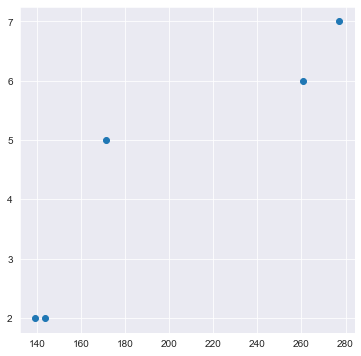

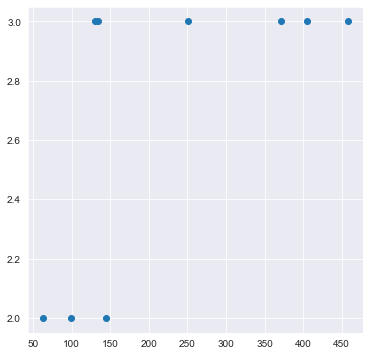

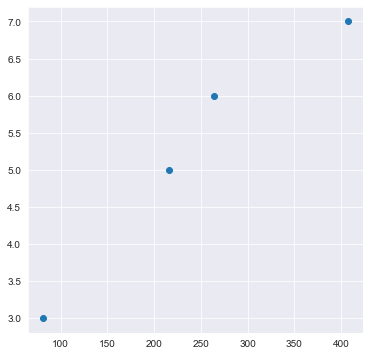

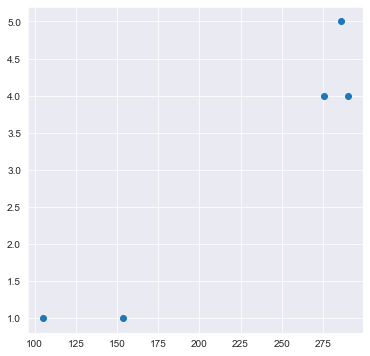

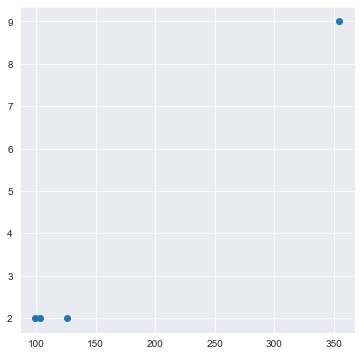

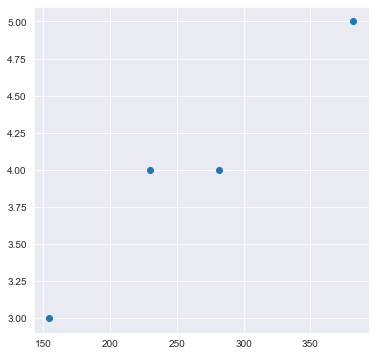

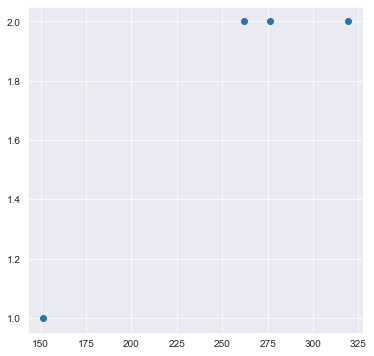

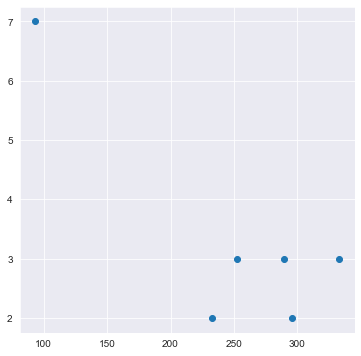

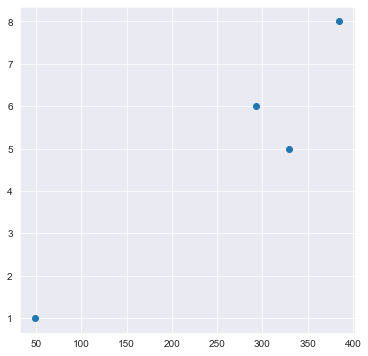

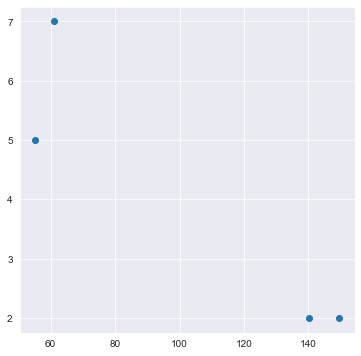

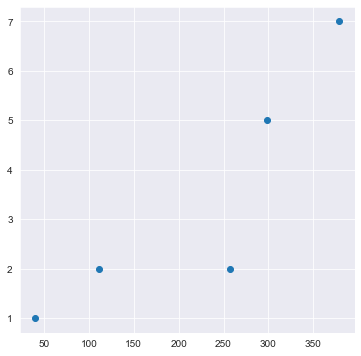

In [15]:
# Looking at the demand curves for the products that I could not find an optimal price for & seeing why
lst = list(res_df[res_df['maximizing_price']=='Could not optimize']['product_id'])[0:11]
for z in lst:
    df = agg_df[agg_df['product_id']==z].copy()
    x = df['unit_price']
    y = df['quantity']
    plt.figure(figsize=(6,6))
    plt.scatter(x,y)
    plt.show()

In [16]:
# It seems that a lot of the demand curves for the un-optimizable products have positive slopes (which could indicate that the goods are giffen goods, 
# and cannot be optimized the same way as standard goods) or they have flat demand curves, and price does not affect the quantity sold at all
#  and also price / revenue cannot be optimized the same way either